## **Environment Setup**

To execute this notebook, activate the main conda environment:

```bash
conda activate main_DE
```

In [1]:
import pandas as pd
import rdkit
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Fragments, rdMolDescriptors, rdchem, PandasTools, EState
import numpy as np

In [2]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, BondType, AllChem as Chem, rdFingerprintGenerator
from rdkit.Chem import rdmolops
from collections import defaultdict
import seaborn as sns

### **Our Compiled Dataset**

In [3]:
start_PBT = pd.read_csv('Datasets/5130compounds_PBT.csv')
start_PBT

,standardized_smiles,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


### Model Training and Predicting for the three splitting strategies

The random, clustering, and cluster-centroids splitting datasets were used to train and test a Chemprop-based model with 10-fold cross-validation. 

### Model Training, Cutoff Selection, and Evaluation Steps with cross-validation


1. **Activate the Conda Environment**

   First, Activate the Conda environment named `chemprop_DE`:

   ```bash
   conda activate chemprop_DE

2. **Initial Model Training with Chemprop**  
   - Trained the model using `chemprop` with the command:
     ```bash
     chemprop_train --data_path /Datasets/file.csv --dataset_type classification --num_folds 10 --split_type cv --features_generator rdkit_2d_normalized --no_features_scaling --save_dir /folder --save_preds --save_smiles_splits
     ```
   - This performed a 10-fold cross-validation, saved the predictions and SMILES splits, and applied RDKit 2D features without scaling.
   
after performing training come back to this notebook

3. **Evaluation of Test Sets and AUC Scores**  
   - Evaluated the test sets and calculated the AUC for each fold.  
   - Identified the fold with the highest AUC and selected this as the best-performing model.

4. **Prediction on the training sets to choose the optimal cutoff for binary classification**  
   - Using the model corresponding to the fold with the best AUC preform predictions on the training sets for each fold.
   - The model corresponding to the fold with the best AUC will help to determine the optimal cutoff for binary classification.

5. **Optimal Cutoff Selection for Binary Classification**  
   - Defined the function `find_cutoff` to identify the cutoff maximizing prediction accuracy:
     - Calculated accuracy for each cutoff value from 0.0 to 1.0 in increments of 0.01 on the training set corresponding to the fold with the best AUC.
     - Selected the cutoff yielding the highest accuracy.
     
6. **Predictions on the test sets and Performance Evaluation**

Using the model from the best-performing fold and the selected optimal cutoff, predictions were made on the test sets. The model’s performance was evaluated using the following metrics:

- **Accuracy**: The overall correctness of the model's predictions on the test set.
- **Sensitivity (Recall)**: The ability of the model to correctly identify positive cases.
- **Specificity**: The ability of the model to correctly identify negative cases.

7. **Predictions on the validation sets and Performance Evaluation**

Predictions were made also for validation sets. **The results reported in the paper related to the performances obtained by the models trained with cross validation (Table S1) are those related to the validation tests for the different splitting strategies.**
The model’s performance was evaluated using the following metrics:

- **Accuracy**: The overall correctness of the model's predictions on the test set.
- **Sensitivity (Recall)**: The ability of the model to correctly identify positive cases.
- **Specificity**: The ability of the model to correctly identify negative cases.

### **Random Splitting training with 10 fold cross-validation**

In [4]:
from sklearn.model_selection import train_test_split

start_PBT

# Split the data into training and test sets (80:20)
#train_random_df, test_random_df = train_test_split(startPBT_correct, test_size=0.2, random_state=42)

# Save the split datasets
#train_random_df.to_csv('Splitting_strategy_datasets/new_train2_random_data.csv', index=False)
#test_random_df.to_csv('Splitting_strategy_datasets/new_test2_random_data.csv', index=False)

,standardized_smiles,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


To run the model training using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**

   First, Activate the Conda environment named **`chemprop_DE`**:

   ```bash
   conda activate chemprop_DE
  
   ```


2. **Run the Command**: Use the following command to initiate training with 10-fold cross-validation:
   ```bash
   chemprop_train --data_path Datasets/5130compounds_PBT.csv \
                  --dataset_type classification \
                  --num_folds 10 \
                  --split_type cv \
                  --features_generator rdkit_2d_normalized \
                  --no_features_scaling \
                  --save_dir RS_CV_results \
                  --save_preds \
                  --save_smiles_splits     
    ```

after completing the **Training command** in bash returns to this notebook

In [6]:
### Elapsed time = 0:33:46

In [7]:
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 
# Base directory where the fold folders are located
base_dir = 'RS_CV_results/'
 
# Lists to store DataFrames of predictions and true values from each fold
dfs_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold10
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'test_preds.csv')
    if os.path.exists(pred_file):
        dfs_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'test_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["smiles", "PBT_label"])
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [8]:
dfs_preds

[                                                smiles     PBT_label
 0        ['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC']  4.731755e-05
 1                                      ['Cc1ccccc1Cl']  8.826101e-03
 2                               ['O=S(=O)(O)C(F)(F)F']  6.312801e-07
 3                                ['CCCCCCC=C1CCCC1=O']  1.686179e-06
 4                         ['CCCCCCCCC=CCCCCCCCC(=O)O']  2.748140e-07
 ..                                                 ...           ...
 508  ['O=C(Nc1ccc(NC(=O)c2cc3ccccc3c(N=Nc3ccc(Cl)cc...  2.083422e-03
 509               ['CC(NCCCCCCNC(C)C(C)(C)C)C(C)(C)C']  5.359218e-02
 510                             ['NCCCN1CCN(CCCN)CC1']  2.774980e-05
 511                            ['C=CC(=O)NCNC(=O)C=C']  1.382867e-09
 512                               ['CN(C)CCCCCCN(C)C']  6.247426e-04
 
 [513 rows x 2 columns],
                                                 smiles     PBT_label
 0    ['O=P(O)(OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...  9.9110

In [9]:
test_preds = pd.read_csv('RS_CV_results/test_preds.csv')
test_preds

,smiles,PBT_label
0,['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC'],4.731755e-05
1,['Cc1ccccc1Cl'],8.826101e-03
2,['O=S(=O)(O)C(F)(F)F'],6.312801e-07
3,['CCCCCCC=C1CCCC1=O'],1.686179e-06
4,['CCCCCCCCC=CCCCCCCCC(=O)O'],2.748140e-07
...,...,...
5125,['CC(C)=CCCC1=CCC(C=O)CC1'],1.544922e-04
5126,['CCN=C=NCCCN(C)C'],1.265570e-07
5127,['CC1(C)CC(NCCCCCCNC2CC(C)(C)NC(C)(C)C2)CC(C)(...,5.497360e-01
5128,['O=C(Nc1ccc(NC(=O)c2cc3ccccc3c(N=Nc3cc(Cl)ccc...,9.345422e-03


In [10]:
# Remove square brackets from SMILES strings
test_preds['smiles'] = test_preds['smiles'].str.strip("['']")
test_preds.columns = ['smiles', 'PBT_pred']
test_preds

,smiles,PBT_pred
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,4.731755e-05
1,Cc1ccccc1Cl,8.826101e-03
2,O=S(=O)(O)C(F)(F)F,6.312801e-07
3,CCCCCCC=C1CCCC1=O,1.686179e-06
4,CCCCCCCCC=CCCCCCCCC(=O)O,2.748140e-07
...,...,...
5125,CC(C)=CCCC1=CCC(C=O)CC1,1.544922e-04
5126,CCN=C=NCCCN(C)C,1.265570e-07
5127,CC1(C)CC(NCCCCCCNC2CC(C)(C)NC(C)(C)C2)CC(C)(C)N1,5.497360e-01
5128,O=C(Nc1ccc(NC(=O)c2cc3ccccc3c(N=Nc3cc(Cl)ccc3C...,9.345422e-03


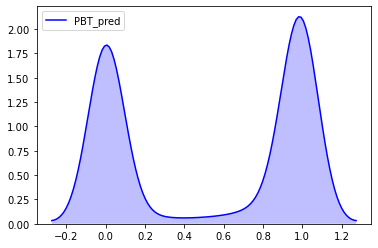

In [11]:
test_fig_preds= sns.kdeplot(test_preds['PBT_pred'], shade= True, color='b')

3. **Evaluation of Test Sets and AUC Scores**  

In [12]:
test_scores = pd.read_csv('RS_CV_results/test_scores.csv')
test_scores

,Task,Mean auc,Standard deviation auc,Fold 0 auc,Fold 1 auc,Fold 2 auc,Fold 3 auc,Fold 4 auc,Fold 5 auc,Fold 6 auc,Fold 7 auc,Fold 8 auc,Fold 9 auc
0,PBT_label,0.990605,0.002542,0.985196,0.991383,0.991228,0.993505,0.994664,0.987869,0.989476,0.991217,0.991139,0.990377


4. **Prediction on the training sets to choose the optimal cutoff for binary classification** 

Chose the fold with the best AUC and predict with that model on the  training sets, we chose **fold 4 auc 0.994664**

The following Bash loop performs predictions on the training set for each fold across all folds (from 0 to 9) using **`chemprop_predict`**.

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

For each fold:

```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path RS_CV_results/fold_${i}/train_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir RS_CV_results/fold_4/ \
                     --preds_path RS_CV_results/fold_${i}/train_predictions.csv 
done
```
after completing the **Predicting command** in bash returns to this notebook

In [13]:
dfs_train_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold20
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'train_predictions.csv')
    if os.path.exists(pred_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "PBT_label"])
        dfs_train_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'train_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "PBT_label"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [14]:
dfs_train_preds

[                     standardized_smiles     PBT_label
 0                          C=C(F)C(=O)OC  7.023358e-08
 1            Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl  9.946437e-01
 2                   Clc1ccc2c(Cl)ccnc2c1  1.638884e-01
 3                     S=c1[nH]c2ccccc2s1  6.626716e-06
 4     Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2  9.979070e-01
 ...                                  ...           ...
 4099                     CN(C)CCOCCN(C)C  3.214126e-04
 4100                        CN(C)CCN(C)C  5.262801e-04
 4101                       CN(C)CCCN(C)C  4.734818e-04
 4102           CCCCCCCCCCCC(=O)N(CCO)CCO  2.165551e-06
 4103        CC(O)CN(CC(C)O)C(=O)c1ccccc1  2.710172e-07
 
 [4104 rows x 2 columns],
                             standardized_smiles     PBT_label
 0     CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC  5.416427e-01
 1                                 C=C(F)C(=O)OC  7.023358e-08
 2                   Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl  9.946437e-01
 3                          Clc1ccc2c(Cl)ccnc2c1

5. **Optimal Cutoff Selection for Binary Classification**

We chose the **fold 4 with the best AUC to find the best cutoff**, to choose the right cutoff to binary classify the PBT predictions we used the following code:

In [15]:
prob = dfs_train_preds[4]
bin_val = dfs_true[4]

In [16]:
def find_cutoff(probabilities, binary_values):
    # Combine probabilities and binary values into tuples
    data = list(zip(probabilities, binary_values))
    # Sort data by probabilities in descending order
#     sorted_data = sorted(data, key=lambda x: x[0], reverse=True)
    # Initialize variables
    best_cutoff = None
    best_accuracy = 0.0
    cutoffs = list(np.arange(0.0, 1.1, 0.01))
    # Iterate through possible cutoff points
#     for i in range(len(sorted_data)):
    for cutoff in cutoffs:
#         cutoff = sorted_data[i][0]
        predicted_classes = [1 if prob >= cutoff else 0 for prob, _ in data]
        accuracy = len([pred for pred, true in zip(predicted_classes, binary_values) if pred == true]) / len(binary_values)
        # Update best cutoff if accuracy improves
        print(f"Cutoff: {cutoff}, Accuracy: {accuracy}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cutoff = cutoff
    return best_cutoff, best_accuracy
 

probabilities = prob['PBT_label']
binary_values = bin_val['PBT_label']

cutoff, accuracy = find_cutoff(probabilities, binary_values)
print(f"Best Cutoff: {cutoff}, Best Accuracy: {accuracy}")

Cutoff: 0.0, Accuracy: 0.5307017543859649
Cutoff: 0.01, Accuracy: 0.9239766081871345
Cutoff: 0.02, Accuracy: 0.9371345029239766
Cutoff: 0.03, Accuracy: 0.9439571150097466
Cutoff: 0.04, Accuracy: 0.9488304093567251
Cutoff: 0.05, Accuracy: 0.9534600389863548
Cutoff: 0.06, Accuracy: 0.9580896686159844
Cutoff: 0.07, Accuracy: 0.9600389863547758
Cutoff: 0.08, Accuracy: 0.9615009746588694
Cutoff: 0.09, Accuracy: 0.9639376218323586
Cutoff: 0.1, Accuracy: 0.9649122807017544
Cutoff: 0.11, Accuracy: 0.9661306042884991
Cutoff: 0.12, Accuracy: 0.9688109161793372
Cutoff: 0.13, Accuracy: 0.969541910331384
Cutoff: 0.14, Accuracy: 0.9705165692007798
Cutoff: 0.15, Accuracy: 0.972953216374269
Cutoff: 0.16, Accuracy: 0.9741715399610137
Cutoff: 0.17, Accuracy: 0.9751461988304093
Cutoff: 0.18, Accuracy: 0.976364522417154
Cutoff: 0.19, Accuracy: 0.9770955165692008
Cutoff: 0.2, Accuracy: 0.9783138401559455
Cutoff: 0.21, Accuracy: 0.9785575048732943
Cutoff: 0.22, Accuracy: 0.9788011695906432
Cutoff: 0.23, Acc

#### **the best cutoff in this case is 0.44 correspondig to an accuracy of 0.98**

In [17]:
threshold = 0.44

for df in dfs_train_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

6. **Predictions on the test sets and Performance Evaluation**

**Predictions on test sets with model for fold 4**

The following Bash loop iterates through each fold (from 0 to 9) to make predictions using **`chemprop_predict`**. For each fold:

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

For each fold:

```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path RS_CV_results/fold_${i}/test_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir RS_CV_results/fold_4/ \
                     --preds_path RS_CV_results/fold_${i}/test_predictions.csv 
done
```
after completing the **Predicting command** in bash returns to this notebook

In [18]:
dfs_test_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold20
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'test_predictions.csv')
    if os.path.exists(pred_file):
        dfs_test_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'test_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "PBT_pred"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [19]:
threshold = 0.44

for df in dfs_test_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

In [20]:
import json
# List to store AUC values for each fold
roc_auc_values_rs = []
 
# Loop through each fold and load the test_scores.json file
for i in range(10):  # Including fold10
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    scores_file = os.path.join(fold_dir, 'test_scores.json')
    if os.path.exists(scores_file):
        with open(scores_file, 'r') as f:
            scores = json.load(f)
            auc = scores.get('auc', None)
            if auc is not None:
                # Check if auc is a list and take the first value
                auc_value = auc[0] if isinstance(auc, list) else auc
                roc_auc_values_rs.append(auc_value)
                print(f" ROC AUC for fold_{i}: {auc_value:.4f}")
            else:
                print(f"ROC AUC not found for fold_{i}")
    else:
        print(f"test_scores.json file not found for fold_{i}")
 
# Compute mean and std for AUC
auc_mean, auc_std = np.mean(roc_auc_values_rs), np.std(roc_auc_values_rs)
 
print("-" * 10)
print(f" ROC AUC: Mean = {auc_mean:.4f}, Std = {auc_std:.4f}")

 ROC AUC for fold_0: 0.9852
 ROC AUC for fold_1: 0.9914
 ROC AUC for fold_2: 0.9912
 ROC AUC for fold_3: 0.9935
 ROC AUC for fold_4: 0.9947
 ROC AUC for fold_5: 0.9879
 ROC AUC for fold_6: 0.9895
 ROC AUC for fold_7: 0.9912
 ROC AUC for fold_8: 0.9911
 ROC AUC for fold_9: 0.9904
----------
 ROC AUC: Mean = 0.9906, Std = 0.0025


In [21]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np

# Lists to store metrics for each fold
accuracies= []
recalls = []
specificities = []

for df_pred, df_true in zip(dfs_test_preds, dfs_true):
    # Assuming the second column contains the true labels
    y_true = df_true.iloc[:, 1].values
    y_pred = df_pred.iloc[:, 1].values

    # Compute metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    
    # Confusion matrix to compute specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate mean and std for each metric
accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
recall_mean, recall_std = np.mean(recalls), np.std(recalls)
specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)

# Print results
print(f"Accuracy: Mean = {accuracy_mean:.4f}, Std = {accuracy_std:.4f}")
print(f"Recall: Mean = {recall_mean:.4f}, Std = {recall_std:.4f}")
print(f"Specificity: Mean = {specificity_mean:.4f}, Std = {specificity_std:.4f}")


Accuracy: Mean = 0.9821, Std = 0.0118
Recall: Mean = 0.9904, Std = 0.0099
Specificity: Mean = 0.9726, Std = 0.0160


7. **Predictions on the validation sets and Performance Evaluation**

**Predictions for validation sets with model for fold 4: performances obtained from the validation tests are the final results present in the Table S1 of the paper**

The following Bash loop performs predictions on the validation set for each fold across all folds (from 0 to 9) using **`chemprop_predict`**.

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

For each fold:

```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path RS_CV_results/fold_${i}/val_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir RS_CV_results/fold_4/ \
                     --preds_path RS_CV_results/fold_${i}/val_predictions.csv 
done
```
after completing the **Predicting command** in bash returns to this notebook

In [22]:
dfs_val_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold20
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'val_predictions.csv')
    if os.path.exists(pred_file):
        dfs_val_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'val_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "0"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [23]:
threshold = 0.44

for df in dfs_val_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

In [24]:
# Lists to store metrics for each fold
accuracies = []
recalls = []
specificities = []

for df_pred, df_true in zip(dfs_val_preds, dfs_true):
    # Assuming the second column contains the true labels
    y_true = df_true.iloc[:, 1].values
    y_pred = df_pred.iloc[:, 1].values

    # Compute metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))

    # Confusion matrix to compute specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate mean and std for each metric
accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
recall_mean, recall_std = np.mean(recalls), np.std(recalls)
specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)

# Print results
print(f"Accuracy: Mean = {accuracy_mean:.4f}, Std = {accuracy_std:.4f}")
print(f"Recall: Mean = {recall_mean:.4f}, Std = {recall_std:.4f}")
print(f"Specificity: Mean = {specificity_mean:.4f}, Std = {specificity_std:.4f}")


Accuracy: Mean = 0.9821, Std = 0.0118
Recall: Mean = 0.9904, Std = 0.0099
Specificity: Mean = 0.9726, Std = 0.0160


Having assessed that the models performed similarly on all 10 cross validation folds as shown by low standard deviation values, **we excluded the presence of bias over a particular subset of data.** Moreover, we could assume that the performance would have been similar when training the models on all data. We then trained the DL-based model across all datasets for random splitting.

### **Random Splitting Chemprop Training on all the data**

In [25]:
#from sklearn.model_selection import train_test_split

#startPBT_correct

# Split the data into training and test sets (80:20)
#train_random_df, test_random_df = train_test_split(startPBT_correct, test_size=0.2, random_state=42)

# Save the split datasets
#train_random_df.to_csv('Splitting_strategy_datasets/new_train2_random_data.csv', index=False)
#test_random_df.to_csv('Splitting_strategy_datasets/new_test2_random_data.csv', index=False)

In [26]:
train_random_df = pd.read_csv('Splitting_strategy_datasets/new_train2_random_data.csv')
train_random_df

,SMILES,PBT_label
0,CCCN(CCC)c1ccc(-c2nc(-c3ccc(N(C)C)cc3)c(-c3ccc...,1
1,C=CC(=O)OCCCCO,0
2,CC(=O)OC1CCC2(C)C(=CCC3C2CCC2(C)C3CCC2(C)OC(C)...,1
3,CCCCOCC1CO1,0
4,CCCCCCCCCCCCCCCCOC(=O)C=CC(=O)O,0
...,...,...
4099,CCCCCCCCCCCCCCCCCC[Si](C)(C)Cl,0
4100,O=C(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1
4101,O=C(O)C(F)(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(...,1
4102,c1ccc(C2=NCCN2)cc1,0


In [27]:
test_random_df = pd.read_csv('Splitting_strategy_datasets/new_test2_random_data.csv')
test_random_df

,SMILES,PBT_label
0,CC(CC(C)C)=NCCNCCN=C(C)CC(C)C,0
1,CC(C)c1cccc2cc3c(ccc4ccccc43)cc12,1
2,CCCCCCCCC=CCCCCCCCC(=O)NCC(C)OC(=O)CC(C(=O)O)S...,0
3,CC(=O)OC1CCC2(C)C(CCC3C2CC(=O)C2(C)C3CC3OC4(CC...,1
4,Oc1c(Br)cc(Cc2cc(Br)c(O)c(Br)c2)cc1Br,1
...,...,...
1021,C=C(C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1
1022,Cc1ccc(Nc2nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n2)cc1,1
1023,FC(F)(Br)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)Br,1
1024,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,1


### **Training and Predicting on all data**

To run the model training using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```
2. **Run the Training Command**
   ```bash
chemprop_train --data_path Splitting_strategy_datasets/new_train2_random_data.csv \
               --dataset_type classification \
               --features_generator rdkit_2d_normalized \
               --no_features_scaling \
               --save_dir RS_results_nok \
               --save_preds
    ```
  - This performed training on all the data, saved the predictions and SMILES splits, and applied RDKit 2D features without scaling.

3. **Run the Prediction Command**
   ```bash
chemprop_predict --test_path Splitting_strategy_datasets/new_test2_random_data.csv \
                 --features_generator rdkit_2d_normalized \
                 --no_features_scaling \
                 --checkpoint_dir RS_results_nok/fold_0/ \
                 --preds_path RS_results_nok/test_finalrandom_predictions.csv
    ```

after completing the **Predicting command** in bash returns to this notebook

In [30]:
test_final_pred = pd.read_csv('RS_results_nok/test_finalrandom_predictions.csv')
test_final_pred

,SMILES,PBT_label
0,CC(CC(C)C)=NCCNCCN=C(C)CC(C)C,1.057900e-02
1,CC(C)c1cccc2cc3c(ccc4ccccc43)cc12,9.996815e-01
2,CCCCCCCCC=CCCCCCCCC(=O)NCC(C)OC(=O)CC(C(=O)O)S...,1.019793e-07
3,CC(=O)OC1CCC2(C)C(CCC3C2CC(=O)C2(C)C3CC3OC4(CC...,9.945195e-01
4,Oc1c(Br)cc(Cc2cc(Br)c(O)c(Br)c2)cc1Br,9.870582e-01
...,...,...
1021,C=C(C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,9.999809e-01
1022,Cc1ccc(Nc2nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n2)cc1,9.997821e-01
1023,FC(F)(Br)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)Br,9.998154e-01
1024,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,9.996549e-01


Find **the best cutoff** according the function defined above

In [31]:
probabilities = test_final_pred['PBT_label']
binary_values = test_random_df['PBT_label']
 
cutoff, accuracy = find_cutoff(probabilities, binary_values)
print(f"Best Cutoff: {cutoff}, Best Accuracy: {accuracy}")

Cutoff: 0.0, Accuracy: 0.5116959064327485
Cutoff: 0.01, Accuracy: 0.9132553606237817
Cutoff: 0.02, Accuracy: 0.9249512670565302
Cutoff: 0.03, Accuracy: 0.928849902534113
Cutoff: 0.04, Accuracy: 0.9307992202729045
Cutoff: 0.05, Accuracy: 0.9317738791423001
Cutoff: 0.06, Accuracy: 0.9346978557504874
Cutoff: 0.07, Accuracy: 0.9346978557504874
Cutoff: 0.08, Accuracy: 0.9366471734892787
Cutoff: 0.09, Accuracy: 0.9366471734892787
Cutoff: 0.1, Accuracy: 0.9366471734892787
Cutoff: 0.11, Accuracy: 0.9385964912280702
Cutoff: 0.12, Accuracy: 0.9385964912280702
Cutoff: 0.13, Accuracy: 0.9405458089668616
Cutoff: 0.14, Accuracy: 0.942495126705653
Cutoff: 0.15, Accuracy: 0.9434697855750487
Cutoff: 0.16, Accuracy: 0.9434697855750487
Cutoff: 0.17, Accuracy: 0.9454191033138402
Cutoff: 0.18, Accuracy: 0.9454191033138402
Cutoff: 0.19, Accuracy: 0.9473684210526315
Cutoff: 0.2, Accuracy: 0.9483430799220273
Cutoff: 0.21, Accuracy: 0.949317738791423
Cutoff: 0.22, Accuracy: 0.9483430799220273
Cutoff: 0.23, Acc

In [32]:
test_final_pred['PBT_bin_pred'] = (test_final_pred['PBT_label'] > 0.64).astype(int)
test_final_pred

,SMILES,PBT_label,PBT_bin_pred
0,CC(CC(C)C)=NCCNCCN=C(C)CC(C)C,1.057900e-02,0
1,CC(C)c1cccc2cc3c(ccc4ccccc43)cc12,9.996815e-01,1
2,CCCCCCCCC=CCCCCCCCC(=O)NCC(C)OC(=O)CC(C(=O)O)S...,1.019793e-07,0
3,CC(=O)OC1CCC2(C)C(CCC3C2CC(=O)C2(C)C3CC3OC4(CC...,9.945195e-01,1
4,Oc1c(Br)cc(Cc2cc(Br)c(O)c(Br)c2)cc1Br,9.870582e-01,1
...,...,...,...
1021,C=C(C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,9.999809e-01,1
1022,Cc1ccc(Nc2nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n2)cc1,9.997821e-01,1
1023,FC(F)(Br)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)Br,9.998154e-01,1
1024,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,9.996549e-01,1


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

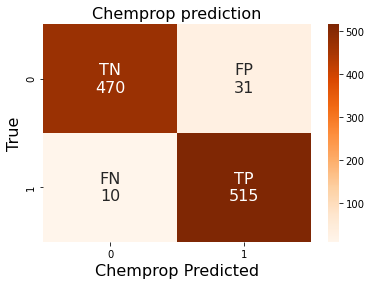

In [34]:
y_true = test_random_df['PBT_label']
y_pred = test_final_pred['PBT_bin_pred']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
ax = sns.heatmap(cm, annot=True, fmt='d',cmap='Oranges' , annot_kws={"size": 16},
            cbar_kws={'shrink': 1, 'orientation': 'vertical'})

# Annotate each cell with the respective quadrant label
quadrant_labels = [['TN', 'FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        text = ax.texts[i*2+j]
        text.set_text(f'{quadrant_labels[i][j]}\n{text.get_text()}')

plt.xlabel('Chemprop Predicted', fontsize = 16)
plt.ylabel('True', fontsize = 16)
plt.title('Chemprop prediction', fontsize = 16)
plt.show()


In [35]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)  # Sensitivity is the same as recall


# AUC
try:
    auc = roc_auc_score(y_true, y_pred)  
except ValueError:
    auc = None  

# Specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')

if auc is not None:
    print(f'AUC: {auc:.2f}')
else:
    print('AUC: Not applicable')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.96
Sensitivity (Recall): 0.98
AUC: 0.96
Specificity: 0.94


### **Clustering Splitting training with 10 fold cross validation**

In [36]:
Clustering_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Clustering_training_PBT.csv')
Clustering_trainmol

,SMILES,PBT_label
0,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
1,Clc1ccc2c(Cl)ccnc2c1,0
2,Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2,1
3,CC(O)C(=O)O,0
4,Cc1ccccc1Cl,0
...,...,...
4059,CN(C)CCCCCCN(C)C,0
4060,CN(C)CCCN(C)C,0
4061,C[N+](C)(C)C1CCCCC1,0
4062,c1ccc(N(CC2CO2)CC2CO2)cc1,0


In [37]:
singleton_testmol = pd.read_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv')
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


To run the model training using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**

   First, Activate the Conda environment named **`chemprop_DE`**:

   ```bash
   conda activate chemprop_DE
   ```
2. **Run the Command**: Use the following command to initiate training with 10-fold cross-validation:
   ```bash
    chemprop_train --data_path Splitting_strategy_datasets/new_Clustering_training_PBT.csv \
                  --dataset_type classification \
                  --num_folds 10 \
                  --split_type cv-no-test \
                  --separate_test_path Splitting_strategy_datasets/new_singletons_test_PBT.csv \
                  --features_generator rdkit_2d_normalized \
                  --no_features_scaling \
                  --save_dir CS_CV_results \
                  --save_preds \
                  --save_smiles_splits    
    ```

after completing the **Training command** in bash returns to this notebook

In [39]:
#Elapsed time = 0:35:08

In [40]:
# Base directory where the fold folders are located
base_dir = 'CS_CV_results/'
 
# Lists to store DataFrames of predictions and true values from each fold
dfs_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold10
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'test_preds.csv')
    if os.path.exists(pred_file):
        dfs_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'test_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["smiles", "PBT_pred"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [41]:
dfs_preds

[                                             smiles     PBT_label
 0     ['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC']  2.132398e-04
 1                                 ['C=C(F)C(=O)OC']  2.191073e-07
 2                            ['S=c1[nH]c2ccccc2s1']  9.760259e-06
 3                            ['O=S(=O)(O)C(F)(F)F']  1.486830e-04
 4     ['COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1']  9.973983e-01
 ...                                             ...           ...
 1060                         ['NCCCN1CCN(CCCN)CC1']  2.549331e-03
 1061                             ['CC(=O)NNC(C)=O']  1.155656e-08
 1062       ['CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1']  1.715435e-02
 1063                        ['C=CC(=O)NCNC(=O)C=C']  1.588786e-09
 1064               ['CC(O)CN(CC(C)O)C(=O)c1ccccc1']  2.795447e-06
 
 [1065 rows x 2 columns],
                                              smiles     PBT_label
 0     ['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC']  1.443349e-05
 1                                

In [42]:
test_preds = pd.read_csv('CS_CV_results/test_preds.csv')
test_preds

,smiles,PBT_label
0,['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC'],2.132398e-04
1,['C=C(F)C(=O)OC'],2.191073e-07
2,['S=c1[nH]c2ccccc2s1'],9.760259e-06
3,['O=S(=O)(O)C(F)(F)F'],1.486830e-04
4,['COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1'],9.973983e-01
...,...,...
10645,['NCCCN1CCN(CCCN)CC1'],3.792771e-03
10646,['CC(=O)NNC(C)=O'],4.788929e-07
10647,['CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1'],2.966635e-01
10648,['C=CC(=O)NCNC(=O)C=C'],5.504774e-08


In [43]:
# Remove square brackets from SMILES strings
test_preds['smiles'] = test_preds['smiles'].str.strip("['']")
test_preds.columns = ['smiles', 'PBT_pred']
test_preds

,smiles,PBT_pred
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,2.132398e-04
1,C=C(F)C(=O)OC,2.191073e-07
2,S=c1[nH]c2ccccc2s1,9.760259e-06
3,O=S(=O)(O)C(F)(F)F,1.486830e-04
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,9.973983e-01
...,...,...
10645,NCCCN1CCN(CCCN)CC1,3.792771e-03
10646,CC(=O)NNC(C)=O,4.788929e-07
10647,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,2.966635e-01
10648,C=CC(=O)NCNC(=O)C=C,5.504774e-08


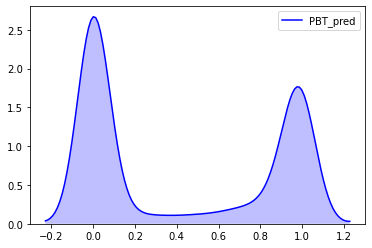

In [44]:
test_fig_preds= sns.kdeplot(test_preds['PBT_pred'], shade= True, color='b')

3. **Evaluation of Test Sets and AUC Scores**

In [45]:
test_scores = pd.read_csv('CS_CV_results/test_scores.csv')
test_scores

,Task,Mean auc,Standard deviation auc,Fold 0 auc,Fold 1 auc,Fold 2 auc,Fold 3 auc,Fold 4 auc,Fold 5 auc,Fold 6 auc,Fold 7 auc,Fold 8 auc,Fold 9 auc
0,PBT_label,0.976277,0.001194,0.976577,0.974845,0.976835,0.977901,0.977367,0.977352,0.976228,0.97673,0.974281,0.974652


#### Chose the fold with the best AUC and retrain with that model on the  training sets **I chose fold 3 auc 0.977901**

4. **Prediction on the training sets to choose the optimal cutoff for binary classification**  

To run the model training using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**

   First, Activate the Conda environment named **`chemprop_DE`**:

   ```bash
   conda activate chemprop_DE
   ```
2. **Run the Command**: Use the following command to initiate training with 10-fold cross-validation:
   ```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path CS_CV_results/fold_${i}/train_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir CS_CV_results/fold_3/ \
                     --preds_path CS_CV_results/fold_${i}/train_predictions.csv 
done  
    ```

after completing the **Training command** in bash returns to this notebook

In [46]:
dfs_train_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'train_predictions.csv')
    if os.path.exists(pred_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "PBT_pred"])
        dfs_train_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'train_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "PBT_label"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [47]:
dfs_train_preds

[                                  SMILES     PBT_label
 0            Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl  9.964849e-01
 1                   Clc1ccc2c(Cl)ccnc2c1  1.333077e-01
 2     Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2  9.994973e-01
 3                            CC(O)C(=O)O  5.421523e-14
 4                            Cc1ccccc1Cl  4.131240e-03
 ...                                  ...           ...
 3652                    CN(C)CCCCCCN(C)C  3.473513e-03
 3653                       CN(C)CCCN(C)C  3.038326e-03
 3654                 C[N+](C)(C)C1CCCCC1  4.649421e-05
 3655           c1ccc(N(CC2CO2)CC2CO2)cc1  1.770298e-05
 3656           CCCCCCCCCCCC(=O)N(CCO)CCO  8.975421e-06
 
 [3657 rows x 2 columns],
                                   SMILES     PBT_label
 0            Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl  9.964849e-01
 1                   Clc1ccc2c(Cl)ccnc2c1  1.333077e-01
 2     Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2  9.994973e-01
 3                            CC(O)C(=O)O  5.421523e-14
 4                  

5. **Optimal Cutoff Selection for Binary Classification**

In [48]:
prob = dfs_train_preds[3]
bin_val = dfs_true[3]

In [49]:
probabilities = prob['PBT_label']
binary_values =bin_val['PBT_label']
 
cutoff, accuracy = find_cutoff(probabilities, binary_values)
print(f"Best Cutoff: {cutoff}, Best Accuracy: {accuracy}")

Cutoff: 0.0, Accuracy: 0.5601421541826135
Cutoff: 0.01, Accuracy: 0.9291962821213778
Cutoff: 0.02, Accuracy: 0.940677966101695
Cutoff: 0.03, Accuracy: 0.948332422088573
Cutoff: 0.04, Accuracy: 0.953526517222526
Cutoff: 0.05, Accuracy: 0.9576271186440678
Cutoff: 0.06, Accuracy: 0.9595407326407873
Cutoff: 0.07, Accuracy: 0.9617277200656096
Cutoff: 0.08, Accuracy: 0.9636413340623291
Cutoff: 0.09, Accuracy: 0.9647348277747403
Cutoff: 0.1, Accuracy: 0.9661016949152542
Cutoff: 0.11, Accuracy: 0.967741935483871
Cutoff: 0.12, Accuracy: 0.9688354291962821
Cutoff: 0.13, Accuracy: 0.9688354291962821
Cutoff: 0.14, Accuracy: 0.9688354291962821
Cutoff: 0.15, Accuracy: 0.9704756697648989
Cutoff: 0.16, Accuracy: 0.9710224166211044
Cutoff: 0.17, Accuracy: 0.9718425369054128
Cutoff: 0.18, Accuracy: 0.972936030617824
Cutoff: 0.19, Accuracy: 0.9740295243302352
Cutoff: 0.2, Accuracy: 0.9743028977583379
Cutoff: 0.21, Accuracy: 0.9753963914707491
Cutoff: 0.22, Accuracy: 0.9764898851831602
Cutoff: 0.23, Accur

### **the best cutoff is 0.62 with an accuracy of 0.987**

In [50]:
threshold = 0.62

for df in dfs_train_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

In [51]:
dfs_train_preds

[                                  SMILES  PBT_label
 0            Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl          1
 1                   Clc1ccc2c(Cl)ccnc2c1          0
 2     Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2          1
 3                            CC(O)C(=O)O          0
 4                            Cc1ccccc1Cl          0
 ...                                  ...        ...
 3652                    CN(C)CCCCCCN(C)C          0
 3653                       CN(C)CCCN(C)C          0
 3654                 C[N+](C)(C)C1CCCCC1          0
 3655           c1ccc(N(CC2CO2)CC2CO2)cc1          0
 3656           CCCCCCCCCCCC(=O)N(CCO)CCO          0
 
 [3657 rows x 2 columns],
                                   SMILES  PBT_label
 0            Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl          1
 1                   Clc1ccc2c(Cl)ccnc2c1          0
 2     Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2          1
 3                            CC(O)C(=O)O          0
 4                            Cc1ccccc1Cl          0
 ...              

6. **Predictions on the test sets and Performance Evaluation**

Predictions on test sets with **model for fold 3**

The following Bash loop performs predictions on the test set for each fold across all folds (from 0 to 9) using **`chemprop_predict`**.

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```
For each fold:


```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path CS_CV_results/fold_${i}/test_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir CS_CV_results/fold_3/ \
                     --preds_path CS_CV_results/fold_${i}/test_predictions.csv 
done
```
after completing the **Predicting command** in bash returns to this notebook

In [52]:
##Elapsed time = 0:00:30

In [53]:
dfs_test_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'test_predictions2.csv')
    if os.path.exists(pred_file):
        dfs_test_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'test_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "0"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [54]:
dfs_test_preds

[                                         SMILES     PBT_label
 0     CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC  1.217436e-03
 1                                 C=C(F)C(=O)OC  1.844833e-07
 2                            S=c1[nH]c2ccccc2s1  4.883021e-05
 3                            O=S(=O)(O)C(F)(F)F  4.553237e-07
 4     COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1  9.951684e-01
 ...                                         ...           ...
 1060                         NCCCN1CCN(CCCN)CC1  1.005524e-03
 1061                             CC(=O)NNC(C)=O  3.071322e-08
 1062       CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1  2.407724e-01
 1063                        C=CC(=O)NCNC(=O)C=C  3.834917e-09
 1064               CC(O)CN(CC(C)O)C(=O)c1ccccc1  2.668307e-06
 
 [1065 rows x 2 columns],
                                          SMILES     PBT_label
 0     CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC  1.217436e-03
 1                                 C=C(F)C(=O)OC  1.844833e-07
 2                         

In [55]:
dfs_true

[                                         SMILES  PBT_label
 0     CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC        1.0
 1                                 C=C(F)C(=O)OC        0.0
 2                            S=c1[nH]c2ccccc2s1        0.0
 3                            O=S(=O)(O)C(F)(F)F        0.0
 4     COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1        1.0
 ...                                         ...        ...
 1060                         NCCCN1CCN(CCCN)CC1        0.0
 1061                             CC(=O)NNC(C)=O        0.0
 1062       CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1        0.0
 1063                        C=CC(=O)NCNC(=O)C=C        0.0
 1064               CC(O)CN(CC(C)O)C(=O)c1ccccc1        0.0
 
 [1065 rows x 2 columns],
                                          SMILES  PBT_label
 0     CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC        1.0
 1                                 C=C(F)C(=O)OC        0.0
 2                            S=c1[nH]c2ccccc2s1        0.0
 3          

In [56]:
threshold = 0.62

for df in dfs_test_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

In [57]:
dfs_test_preds

[                                         SMILES  PBT_label
 0     CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC          0
 1                                 C=C(F)C(=O)OC          0
 2                            S=c1[nH]c2ccccc2s1          0
 3                            O=S(=O)(O)C(F)(F)F          0
 4     COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1          1
 ...                                         ...        ...
 1060                         NCCCN1CCN(CCCN)CC1          0
 1061                             CC(=O)NNC(C)=O          0
 1062       CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1          0
 1063                        C=CC(=O)NCNC(=O)C=C          0
 1064               CC(O)CN(CC(C)O)C(=O)c1ccccc1          0
 
 [1065 rows x 2 columns],
                                          SMILES  PBT_label
 0     CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC          0
 1                                 C=C(F)C(=O)OC          0
 2                            S=c1[nH]c2ccccc2s1          0
 3          

In [58]:
# List to store AUC values for each fold
roc_auc_values = []
 
# Loop through each fold and load the test_scores.json file
for i in range(10):  # Including fold10
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    scores_file = os.path.join(fold_dir, 'test_scores.json')
    if os.path.exists(scores_file):
        with open(scores_file, 'r') as f:
            scores = json.load(f)
            auc = scores.get('auc', None)
            if auc is not None:
                # Check if auc is a list and take the first value
                auc_value = auc[0] if isinstance(auc, list) else auc
                roc_auc_values.append(auc_value)
                print(f" ROC AUC for fold_{i}: {auc_value:.4f}")
            else:
                print(f"ROC AUC not found for fold_{i}")
    else:
        print(f"test_scores.json file not found for fold_{i}")
 
# Compute mean and std for AUC
auc_mean, auc_std = np.mean(roc_auc_values), np.std(roc_auc_values)
 
print("-" * 10)
print(f" ROC AUC: Mean = {auc_mean:.4f}, Std = {auc_std:.4f}")

 ROC AUC for fold_0: 0.9766
 ROC AUC for fold_1: 0.9748
 ROC AUC for fold_2: 0.9768
 ROC AUC for fold_3: 0.9779
 ROC AUC for fold_4: 0.9774
 ROC AUC for fold_5: 0.9774
 ROC AUC for fold_6: 0.9762
 ROC AUC for fold_7: 0.9767
 ROC AUC for fold_8: 0.9743
 ROC AUC for fold_9: 0.9747
----------
 ROC AUC: Mean = 0.9763, Std = 0.0012


In [59]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np

# Lists to store metrics for each fold
accuracies = []
recalls = []
specificities = []

for df_pred, df_true in zip(dfs_test_preds, dfs_true):
    # Assuming the second column contains the true labels
    y_true = df_true.iloc[:, 1].values
    y_pred = df_pred.iloc[:, 1].values

    # Compute metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))

    # Confusion matrix to compute specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate mean and std for each metric
accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
recall_mean, recall_std = np.mean(recalls), np.std(recalls)
specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)

# Print results
print(f"Accuracy: Mean = {accuracy_mean:.4f}, Std = {accuracy_std:.4f}")
print(f"Recall: Mean = {recall_mean:.4f}, Std = {recall_std:.4f}")
print(f"Specificity: Mean = {specificity_mean:.4f}, Std = {specificity_std:.4f}")


Accuracy: Mean = 0.9305, Std = 0.0000
Recall: Mean = 0.9362, Std = 0.0000
Specificity: Mean = 0.9265, Std = 0.0000


I'm only evaluating on one test fold that is 1065 singletons, I’d get zero standard deviation since there’s only one value per metric. That's why I will remake the prediction on validation tests and show thew results that are also reposted in **Table S1** of the SI of the paper

7. **Predictions on the validation sets and Performance Evaluation**

Predictions on validation sets with model for fold 3. **Performances obtained after predictions on validations sets are the results present in Table S1     of the paper**

The following Bash loop performs predictions on the validation set for each fold across all folds (from 0 to 9) using **`chemprop_predict`**.

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

For each fold:

```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path CS_CV_results/fold_${i}/val_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir RS_CV_results/fold_3/ \
                     --preds_path RS_CV_results/fold_${i}/val_predictions.csv 
done
```

after completing the **Predicting command** in bash returns to this notebook

In [60]:
dfs_val_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'val_predictions.csv')
    if os.path.exists(pred_file):
        dfs_val_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'val_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "0"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [61]:
dfs_val_preds

[                                                SMILES     PBT_label
 0                              CCCCCCCCCCCCCCCCCC(=O)O  1.139194e-06
 1                     c1ccc2cc3c4ccccc4c4ccccc4c3cc2c1  9.993458e-01
 2                          Cc1cc2c3ccccc3ccc2c2ccccc12  9.981424e-01
 3                                        CC(=O)CC(C)=O  2.578996e-07
 4                       CCCCCCCCCCCCc1ccccc1S(=O)(=O)O  3.281617e-05
 ..                                                 ...           ...
 402                             CCCCCCCCCCCCCCCC(=O)OC  1.520973e-05
 403                             COS(=O)(=O)c1ccc(C)cc1  2.893720e-07
 404                  CCCCCCCC[N+](C)(CCCCCCCC)CCCCCCCC  2.748017e-03
 405                            CC(C)=CCCC1=CCC(C=O)CC1  3.081729e-04
 406  O=C(Nc1cccc2c(NC(=O)c3cc4ccccc4c(N=Nc4cccc(Cl)...  2.008240e-03
 
 [407 rows x 2 columns],
                                                 SMILES  PBT_label
 0                                    CCCCCCC=C1CCCC1=O   0.000002

In [62]:
threshold = 0.62

for df in dfs_val_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

In [63]:
# Lists to store metrics for each fold
accuracies = []
recalls = []
specificities = []

for df_pred, df_true in zip(dfs_val_preds, dfs_true):
    # Assuming the second column contains the true labels
    y_true = df_true.iloc[:, 1].values
    y_pred = df_pred.iloc[:, 1].values

    # Compute metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))

    # Confusion matrix to compute specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate mean and std for each metric
accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
recall_mean, recall_std = np.mean(recalls), np.std(recalls)
specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)

# Print results
print(f"Accuracy: Mean = {accuracy_mean:.4f}, Std = {accuracy_std:.4f}")
print(f"Recall: Mean = {recall_mean:.4f}, Std = {recall_std:.4f}")
print(f"Specificity: Mean = {specificity_mean:.4f}, Std = {specificity_std:.4f}")


Accuracy: Mean = 0.9860, Std = 0.0065
Recall: Mean = 0.9920, Std = 0.0063
Specificity: Mean = 0.9785, Std = 0.0083


Cross-validation is just to determine that the model performs well across different splits of the data (i.e. it's not biased over a particular split of the data, and it's not overfitting too much)
Metrics across all different folds look similar, that's why the model is not biased by different split of the data

### **Clustering Splitting Chemprop Training on all the data**

In [64]:
Clustering_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Clustering_training_PBT.csv')
Clustering_trainmol

,SMILES,PBT_label
0,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
1,Clc1ccc2c(Cl)ccnc2c1,0
2,Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2,1
3,CC(O)C(=O)O,0
4,Cc1ccccc1Cl,0
...,...,...
4059,CN(C)CCCCCCN(C)C,0
4060,CN(C)CCCN(C)C,0
4061,C[N+](C)(C)C1CCCCC1,0
4062,c1ccc(N(CC2CO2)CC2CO2)cc1,0


In [65]:
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


### **Training and Predicting on all data**

To run the model training using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```
2. **Run the Training Command**
   ```bash
chemprop_train --data_path Splitting_strategy_datasets/new_Clustering_training_PBT.csv \
               --dataset_type classification \
               --features_generator rdkit_2d_normalized \
               --no_features_scaling \
               --save_dir CS_results_nok \
               --save_preds
    ```
  - This performed training on all the data, saved the predictions and SMILES splits, and applied RDKit 2D features without scaling.

3. **Run the Prediction Command**
   ```bash
chemprop_predict --test_path Splitting_strategy_datasets/new_singletons_test_PBT.csv \
                 --features_generator rdkit_2d_normalized \
                 --no_features_scaling \
                 --checkpoint_dir CS_results_nok/fold_0/ \
                 --preds_path CS_results_nok/test_singletons_final_predictions.csv

    ```

after completing the **Predicting command** in bash returns to this notebook

In [67]:
##Elapsed time = 0:04:26

In [69]:
test_final_pred = pd.read_csv('CS_results_nok/test_singletons_final_predictions.csv')
test_final_pred

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1.257244e-04
1,C=C(F)C(=O)OC,3.458049e-07
2,S=c1[nH]c2ccccc2s1,9.820716e-06
3,O=S(=O)(O)C(F)(F)F,4.582936e-06
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,9.957540e-01
...,...,...
1060,NCCCN1CCN(CCCN)CC1,1.460567e-03
1061,CC(=O)NNC(C)=O,5.326066e-08
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,1.984906e-01
1063,C=CC(=O)NCNC(=O)C=C,1.012073e-08


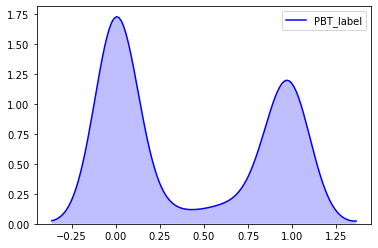

In [70]:
test_fig_preds= sns.kdeplot(test_final_pred['PBT_label'], shade= True, color='b')

In [71]:
probabilities = test_final_pred['PBT_label']
binary_values = singleton_testmol['PBT_label']
 
cutoff, accuracy = find_cutoff(probabilities, binary_values)
print(f"Best Cutoff: {cutoff}, Best Accuracy: {accuracy}")

Cutoff: 0.0, Accuracy: 0.41220657276995304
Cutoff: 0.01, Accuracy: 0.8619718309859155
Cutoff: 0.02, Accuracy: 0.8779342723004695
Cutoff: 0.03, Accuracy: 0.8854460093896713
Cutoff: 0.04, Accuracy: 0.8938967136150234
Cutoff: 0.05, Accuracy: 0.8985915492957747
Cutoff: 0.06, Accuracy: 0.9014084507042254
Cutoff: 0.07, Accuracy: 0.9004694835680751
Cutoff: 0.08, Accuracy: 0.9023474178403755
Cutoff: 0.09, Accuracy: 0.9023474178403755
Cutoff: 0.1, Accuracy: 0.9051643192488263
Cutoff: 0.11, Accuracy: 0.9070422535211268
Cutoff: 0.12, Accuracy: 0.907981220657277
Cutoff: 0.13, Accuracy: 0.907981220657277
Cutoff: 0.14, Accuracy: 0.9098591549295775
Cutoff: 0.15, Accuracy: 0.9107981220657277
Cutoff: 0.16, Accuracy: 0.9117370892018779
Cutoff: 0.17, Accuracy: 0.9117370892018779
Cutoff: 0.18, Accuracy: 0.9126760563380282
Cutoff: 0.19, Accuracy: 0.9136150234741784
Cutoff: 0.2, Accuracy: 0.9154929577464789
Cutoff: 0.21, Accuracy: 0.9154929577464789
Cutoff: 0.22, Accuracy: 0.9154929577464789
Cutoff: 0.23, A

### **the best cutoff is 0.59 with an accuracy of 0.938**

In [72]:
test_final_pred['PBT_bin_pred'] = (test_final_pred['PBT_label'] > 0.59).astype(int)
test_final_pred

,SMILES,PBT_label,PBT_bin_pred
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1.257244e-04,0
1,C=C(F)C(=O)OC,3.458049e-07,0
2,S=c1[nH]c2ccccc2s1,9.820716e-06,0
3,O=S(=O)(O)C(F)(F)F,4.582936e-06,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,9.957540e-01,1
...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,1.460567e-03,0
1061,CC(=O)NNC(C)=O,5.326066e-08,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,1.984906e-01,0
1063,C=CC(=O)NCNC(=O)C=C,1.012073e-08,0


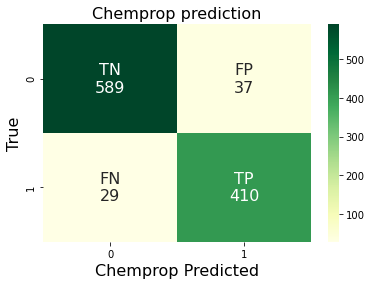

In [73]:
# Assuming test_final_pred['PBT_bin_pred'] contains your prediction values
# and test_random_df['PBT_label'] contains the experimental (true) values
y_true = singleton_testmol['PBT_label']
y_pred = test_final_pred['PBT_bin_pred']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
ax = sns.heatmap(cm, annot=True, fmt='d',cmap='YlGn' , annot_kws={"size": 16},
            cbar_kws={'shrink': 1, 'orientation': 'vertical'})

# Annotate each cell with the respective quadrant label
quadrant_labels = [['TN', 'FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        text = ax.texts[i*2+j]
        text.set_text(f'{quadrant_labels[i][j]}\n{text.get_text()}')

plt.xlabel('Chemprop Predicted', fontsize = 16)
plt.ylabel('True', fontsize = 16)
plt.title('Chemprop prediction', fontsize = 16)
#plt.savefig('/home/dominga.evangelista/dominga/chemprop/PBT_chemprop/cm2_clusteringsplitright_chemprop', dpi=300, bbox_inches='tight')
plt.show()


In [74]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)  # Sensitivity is the same as recall

# AUC
try:
    auc = roc_auc_score(y_true, y_pred)  # y_pred_prob should be the predicted probabilities
except ValueError:
    auc = None  # Handle cases where AUC can't be computed, e.g., with a single class in y_true

# Specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')

if auc is not None:
    print(f'AUC: {auc:.2f}')
else:
    print('AUC: Not applicable')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.94
Sensitivity (Recall): 0.93
AUC: 0.94
Specificity: 0.94


### **Cluster-centroids splitting training with 10 fold cross validation**

In [75]:
Centres_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv')
Centres_trainmol

,SMILES,PBT_label
0,Clc1ccc2c(Cl)ccnc2c1,0
1,NC(=Nc1ccccc1)Nc1ccccc1,0
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
3,COC(=O)C(F)(F)F,0
4,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


In [76]:
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


To run the model training using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**

   First, Activate the Conda environment named **`chemprop_DE`**:

   ```bash
   conda activate chemprop_DE
   ```
2. **Run the Command**: Use the following command to initiate training with 10-fold cross-validation:
   ```bash
chemprop_train --data_path Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv \
                  --dataset_type classification \
                  --num_folds 10 \
                  --split_type cv-no-test \
                  --separate_test_path Splitting_strategy_datasets/new_singletons_test_PBT.csv \
                  --features_generator rdkit_2d_normalized \
                  --no_features_scaling \
                  --save_dir CC_CV_results \
                  --save_preds \
                  --save_smiles_splits
  
    ```
 after completing the **Training command** in bash returns to this notebook

In [78]:
##Elapsed time = 0:09:02

In [79]:
# Base directory where the fold folders are located
base_dir = 'CC_CV_results/'
 
# Lists to store DataFrames of predictions and true values from each fold
dfs_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold10
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'test_preds.csv')
    if os.path.exists(pred_file):
        dfs_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'test_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["smiles", "1"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [80]:
dfs_preds

[                                             smiles  PBT_label
 0     ['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC']   0.384699
 1                                 ['C=C(F)C(=O)OC']   0.010371
 2                            ['S=c1[nH]c2ccccc2s1']   0.093544
 3                            ['O=S(=O)(O)C(F)(F)F']   0.134915
 4     ['COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1']   0.847470
 ...                                             ...        ...
 1060                         ['NCCCN1CCN(CCCN)CC1']   0.009641
 1061                             ['CC(=O)NNC(C)=O']   0.002046
 1062       ['CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1']   0.614556
 1063                        ['C=CC(=O)NCNC(=O)C=C']   0.002378
 1064               ['CC(O)CN(CC(C)O)C(=O)c1ccccc1']   0.011983
 
 [1065 rows x 2 columns],
                                              smiles  PBT_label
 0     ['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC']   0.305900
 1                                 ['C=C(F)C(=O)OC']   0.005408
 2          

In [81]:
test_preds = pd.read_csv('CC_CV_results/test_preds.csv')
test_preds

,smiles,PBT_label
0,['CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC'],0.384699
1,['C=C(F)C(=O)OC'],0.010371
2,['S=c1[nH]c2ccccc2s1'],0.093544
3,['O=S(=O)(O)C(F)(F)F'],0.134915
4,['COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1'],0.847470
...,...,...
10645,['NCCCN1CCN(CCCN)CC1'],0.008288
10646,['CC(=O)NNC(C)=O'],0.000782
10647,['CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1'],0.746334
10648,['C=CC(=O)NCNC(=O)C=C'],0.000899


In [82]:
# Remove square brackets from SMILES strings
test_preds['smiles'] = test_preds['smiles'].str.strip("['']")

test_preds.columns = ['smiles', 'PBT_pred']

In [83]:
test_preds

,smiles,PBT_pred
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,0.384699
1,C=C(F)C(=O)OC,0.010371
2,S=c1[nH]c2ccccc2s1,0.093544
3,O=S(=O)(O)C(F)(F)F,0.134915
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,0.847470
...,...,...
10645,NCCCN1CCN(CCCN)CC1,0.008288
10646,CC(=O)NNC(C)=O,0.000782
10647,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0.746334
10648,C=CC(=O)NCNC(=O)C=C,0.000899


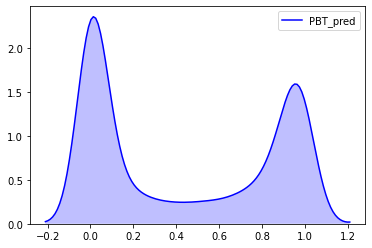

In [84]:
test_fig_preds= sns.kdeplot(test_preds['PBT_pred'], shade= True, color='b')

3. **Evaluation of Test Sets and AUC Scores**

In [85]:
test_scores = pd.read_csv('CC_CV_results/test_scores.csv')
test_scores

,Task,Mean auc,Standard deviation auc,Fold 0 auc,Fold 1 auc,Fold 2 auc,Fold 3 auc,Fold 4 auc,Fold 5 auc,Fold 6 auc,Fold 7 auc,Fold 8 auc,Fold 9 auc
0,PBT_label,0.951213,0.002743,0.945165,0.947801,0.952808,0.950144,0.95434,0.952743,0.954467,0.951505,0.951935,0.951218


4. **Prediction on the training sets to choose the optimal cutoff for binary classification** 

Chose the fold with the best AUC and predict with that model on the  training sets, we chose **fold 6 auc 0.9555**

The following Bash loop performs predictions on the training set for each fold across all folds (from 0 to 9) using **`chemprop_predict`**.

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

For each fold:

```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path CC_CV_results/fold_${i}/train_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir CC_CV_results/fold_6/ \
                     --preds_path CC_CV_results/fold_${i}/train_predictions.csv 
done
```
after completing the **Predicting command** in bash returns to this notebook

In [86]:
dfs_train_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold20
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'train_predictions.csv')
    if os.path.exists(pred_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "PBT_pred"])
        dfs_train_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'train_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "PBT_label"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [87]:
dfs_train_preds

[                                                SMILES  PBT_label
 0                                 Clc1ccc2c(Cl)ccnc2c1   0.517718
 1                              NC(=Nc1ccccc1)Nc1ccccc1   0.007075
 2    O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...   0.993808
 3                                      COC(=O)C(F)(F)F   0.016112
 4                           O=C1c2ccccc2C(=O)c2ccccc21   0.047238
 ..                                                 ...        ...
 520                                           CNC(N)=O   0.000059
 521                             CC(C)C(NC(N)=O)NC(N)=O   0.000149
 522               C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1   0.240100
 523  CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...   0.567464
 524                          c1ccc(N(CC2CO2)CC2CO2)cc1   0.021870
 
 [525 rows x 2 columns],
                                                 SMILES  PBT_label
 0                                 Clc1ccc2c(Cl)ccnc2c1   0.517718
 1                              NC(

5. **Optimal Cutoff Selection for Binary Classification** 

In [88]:
### We chose fold 6  that has the best AUC to find the best cutoff

In [89]:
prob = dfs_train_preds[6]
bin_val = dfs_true[6]

In [90]:
probabilities = prob['PBT_label']
binary_values = bin_val['PBT_label']

cutoff, accuracy = find_cutoff(probabilities, binary_values)
print(f"Best Cutoff: {cutoff}, Best Accuracy: {accuracy}")

Cutoff: 0.0, Accuracy: 0.4847908745247148
Cutoff: 0.01, Accuracy: 0.8326996197718631
Cutoff: 0.02, Accuracy: 0.8555133079847909
Cutoff: 0.03, Accuracy: 0.8783269961977186
Cutoff: 0.04, Accuracy: 0.8878326996197718
Cutoff: 0.05, Accuracy: 0.8935361216730038
Cutoff: 0.06, Accuracy: 0.8973384030418251
Cutoff: 0.07, Accuracy: 0.8992395437262357
Cutoff: 0.08, Accuracy: 0.9049429657794676
Cutoff: 0.09, Accuracy: 0.9144486692015209
Cutoff: 0.1, Accuracy: 0.9182509505703422
Cutoff: 0.11, Accuracy: 0.9182509505703422
Cutoff: 0.12, Accuracy: 0.9220532319391636
Cutoff: 0.13, Accuracy: 0.9220532319391636
Cutoff: 0.14, Accuracy: 0.9220532319391636
Cutoff: 0.15, Accuracy: 0.9277566539923955
Cutoff: 0.16, Accuracy: 0.9296577946768061
Cutoff: 0.17, Accuracy: 0.9315589353612167
Cutoff: 0.18, Accuracy: 0.935361216730038
Cutoff: 0.19, Accuracy: 0.935361216730038
Cutoff: 0.2, Accuracy: 0.9391634980988594
Cutoff: 0.21, Accuracy: 0.9391634980988594
Cutoff: 0.22, Accuracy: 0.9391634980988594
Cutoff: 0.23, Ac

### **the best cutoff is 0.57 with an accuracy of 0.969**

In [91]:
threshold = 0.57

for df in dfs_train_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

6. **Predictions on the test sets and Performance Evaluation**

Predictions on test sets with **model for fold6**

The following Bash loop performs predictions on the test set for each fold across all folds (from 0 to 9) using **`chemprop_predict`**.

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

For each fold:

```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path CC_CV_results/fold_${i}/test_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir CC_CV_results/fold_6/ \
                     --preds_path CC_CV_results/fold_${i}/test_predictions.csv 
done
```
after completing the **Predicting command** in bash returns to this notebook

In [92]:
dfs_test_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold20
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'test_predictions.csv')
    if os.path.exists(pred_file):
        dfs_test_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'test_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "0"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [93]:
threshold = 0.57

for df in dfs_test_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

In [94]:
import json
# List to store AUC values for each fold
roc_auc_values = []
 
# Loop through each fold and load the test_scores.json file
for i in range(10):  # Including fold10
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    scores_file = os.path.join(fold_dir, 'test_scores.json')
    if os.path.exists(scores_file):
        with open(scores_file, 'r') as f:
            scores = json.load(f)
            auc = scores.get('auc', None)
            if auc is not None:
                # Check if auc is a list and take the first value
                auc_value = auc[0] if isinstance(auc, list) else auc
                roc_auc_values.append(auc_value)
                print(f" ROC AUC for fold_{i}: {auc_value:.4f}")
            else:
                print(f"ROC AUC not found for fold_{i}")
    else:
        print(f"test_scores.json file not found for fold_{i}")
 
# Compute mean and std for AUC
auc_mean, auc_std = np.mean(roc_auc_values), np.std(roc_auc_values)
 
print("-" * 10)
print(f" ROC AUC: Mean = {auc_mean:.4f}, Std = {auc_std:.4f}")

 ROC AUC for fold_0: 0.9452
 ROC AUC for fold_1: 0.9478
 ROC AUC for fold_2: 0.9528
 ROC AUC for fold_3: 0.9501
 ROC AUC for fold_4: 0.9543
 ROC AUC for fold_5: 0.9527
 ROC AUC for fold_6: 0.9545
 ROC AUC for fold_7: 0.9515
 ROC AUC for fold_8: 0.9519
 ROC AUC for fold_9: 0.9512
----------
 ROC AUC: Mean = 0.9512, Std = 0.0027


In [95]:
accuracies = []
recalls = []
 
for df_pred, df_true in zip(dfs_test_preds, dfs_true):
    # Assuming the second column contains the true labels
    y_true = df_true.iloc[:, 1].values
    y_pred = df_pred.iloc[:, 1].values
    # Compute metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
 
    
# Calculate mean and std for each metric
accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
recall_mean, recall_std = np.mean(recalls), np.std(recalls)
 
print(f"Accuracy: Mean = {accuracy_mean:.4f}, Std = {accuracy_std:.4f}")
print(f"Recall: Mean = {recall_mean:.4f}, Std = {recall_std:.4f}")

Accuracy: Mean = 0.9033, Std = 0.0000
Recall: Mean = 0.9066, Std = 0.0000


I'm only evaluating on one test fold that is 1065 singletons, I’d get zero standard deviation since there’s only one value per metric. That's why I will remake the prediction on validation tests and show thew results tha are also reported in **Table S1** of the SI of the paper.

7. **Predictions on the validation sets and Performance Evaluation**

Predictions on validation sets with model for fold 6. **Performances obtained after predictions on validations sets are the results present in Table S1     of the paper**

The following Bash loop performs predictions on the validation set for each fold across all folds (from 0 to 9) using **`chemprop_predict`**.

To run the model prediction using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

**Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

For each fold:

```bash
for i in {0..9}; do
    echo "Predicting for fold $i..."
    chemprop_predict --test_path CC_CV_results/fold_${i}/val_smiles.csv \
                     --features_generator rdkit_2d_normalized \
                     --no_features_scaling \
                     --checkpoint_dir CC_CV_results/fold_6/ \
                     --preds_path CC_CV_results/fold_${i}/val_predictions.csv 
done
```

after completing the **Predicting command** in bash returns to this notebook

In [96]:
dfs_val_preds = []
dfs_true = []
 
# Loop through each fold and load the prediction and true value files
for i in range(10):  # Including fold20
    fold_dir = os.path.join(base_dir, f"fold_{i}")
    # Load predictions
    pred_file = os.path.join(fold_dir, 'val_predictions.csv')
    if os.path.exists(pred_file):
        dfs_val_preds.append(pd.read_csv(pred_file))
    else:
        print(f"Prediction file not found for fold_{i}")
    # Load true values
    true_file = os.path.join(fold_dir, 'val_full.csv')
    if os.path.exists(true_file):
        df = pd.read_csv(true_file, header=None, names=["SMILES", "0"])# Assign column names
        #dfs_true.append(df)
        dfs_true.append(pd.read_csv(true_file))
    else:
        print(f"True values file not found for fold_{i}")

In [97]:
threshold = 0.57

for df in dfs_val_preds:
    df.iloc[:, 1] = (df.iloc[:, 1] > threshold).astype(int)

In [98]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np

# Lists to store metrics for each fold
accuracies = []
recalls = []
specificities = []

for df_pred, df_true in zip(dfs_val_preds, dfs_true):
    # Assuming the second column contains the true labels
    y_true = df_true.iloc[:, 1].values
    y_pred = df_pred.iloc[:, 1].values

    # Compute metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))

    # Confusion matrix to compute specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Calculate mean and std for each metric
accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
recall_mean, recall_std = np.mean(recalls), np.std(recalls)
specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)

# Print results
print(f"Accuracy: Mean = {accuracy_mean:.4f}, Std = {accuracy_std:.4f}")
print(f"Recall: Mean = {recall_mean:.4f}, Std = {recall_std:.4f}")
print(f"Specificity: Mean = {specificity_mean:.4f}, Std = {specificity_std:.4f}")


Accuracy: Mean = 0.9639, Std = 0.0261
Recall: Mean = 0.9701, Std = 0.0464
Specificity: Mean = 0.9589, Std = 0.0343


### **Cluster Centroids Splitting Chemprop Training on all the data**

In [99]:
Centres_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv')
Centres_trainmol

,SMILES,PBT_label
0,Clc1ccc2c(Cl)ccnc2c1,0
1,NC(=Nc1ccccc1)Nc1ccccc1,0
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
3,COC(=O)C(F)(F)F,0
4,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


In [100]:
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


### **Training and Predicting on all data**

To run the model training using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```
2. **Run the Training Command**
   ```bash
chemprop_train --data_path Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv \
               --dataset_type classification \
               --features_generator rdkit_2d_normalized \
               --no_features_scaling \
               --save_dir CC_results_nok \
               --save_preds
    ```
  - This performed training on all the data, saved the predictions and SMILES splits, and applied RDKit 2D features without scaling.

3. **Run the Prediction Command**
   ```bash
chemprop_predict --test_path Splitting_strategy_datasets/new_singletons_test_PBT.csv \
                 --features_generator rdkit_2d_normalized \
                 --no_features_scaling \
                 --checkpoint_dir CC_results_nok/fold_0/ \
                 --preds_path CC_results_nok/test_final_CC_predictions.csv
    ```

after completing the **Predicting command** in bash returns to this notebook

In [102]:
##Elapsed time = 0:00:38

In [104]:
##Elapsed time = 0:00:29

In [105]:
test_final_pred = pd.read_csv('CC_results_nok/test_final_CC_predictions.csv')

In [106]:
test_final_pred

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,0.298063
1,C=C(F)C(=O)OC,0.000273
2,S=c1[nH]c2ccccc2s1,0.005313
3,O=S(=O)(O)C(F)(F)F,0.000527
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,0.762580
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0.003541
1061,CC(=O)NNC(C)=O,0.000040
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0.382319
1063,C=CC(=O)NCNC(=O)C=C,0.000039


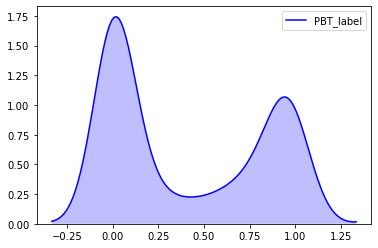

In [107]:
test_fig_preds= sns.kdeplot(test_final_pred['PBT_label'], shade= True, color='b')

In [108]:
probabilities = test_final_pred['PBT_label']
binary_values = singleton_testmol['PBT_label']
 
cutoff, accuracy = find_cutoff(probabilities, binary_values)
print(f"Best Cutoff: {cutoff}, Best Accuracy: {accuracy}")

Cutoff: 0.0, Accuracy: 0.41220657276995304
Cutoff: 0.01, Accuracy: 0.7661971830985915
Cutoff: 0.02, Accuracy: 0.8065727699530516
Cutoff: 0.03, Accuracy: 0.8253521126760563
Cutoff: 0.04, Accuracy: 0.8347417840375587
Cutoff: 0.05, Accuracy: 0.8375586854460094
Cutoff: 0.06, Accuracy: 0.8450704225352113
Cutoff: 0.07, Accuracy: 0.8497652582159625
Cutoff: 0.08, Accuracy: 0.8535211267605634
Cutoff: 0.09, Accuracy: 0.8582159624413146
Cutoff: 0.1, Accuracy: 0.8647887323943662
Cutoff: 0.11, Accuracy: 0.8647887323943662
Cutoff: 0.12, Accuracy: 0.8666666666666667
Cutoff: 0.13, Accuracy: 0.8685446009389671
Cutoff: 0.14, Accuracy: 0.8723004694835681
Cutoff: 0.15, Accuracy: 0.8723004694835681
Cutoff: 0.16, Accuracy: 0.8760563380281691
Cutoff: 0.17, Accuracy: 0.8769953051643192
Cutoff: 0.18, Accuracy: 0.8798122065727699
Cutoff: 0.19, Accuracy: 0.8854460093896713
Cutoff: 0.2, Accuracy: 0.8873239436619719
Cutoff: 0.21, Accuracy: 0.8873239436619719
Cutoff: 0.22, Accuracy: 0.888262910798122
Cutoff: 0.23, 

In [109]:
test_final_pred['PBT_bin_pred'] = (test_final_pred['PBT_label'] > 0.51).astype(int)
test_final_pred.columns = [['SMILES', 'PBT_pred', 'PBT_bin_pred']]
test_final_pred


,SMILES,PBT_pred,PBT_bin_pred
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,0.298063,0
1,C=C(F)C(=O)OC,0.000273,0
2,S=c1[nH]c2ccccc2s1,0.005313,0
3,O=S(=O)(O)C(F)(F)F,0.000527,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,0.762580,1
...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,0.003541,0
1061,CC(=O)NNC(C)=O,0.000040,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0.382319,0
1063,C=CC(=O)NCNC(=O)C=C,0.000039,0


In [110]:
#test_final_pred.to_csv('singletons1065_DLprediction.csv', index = False)

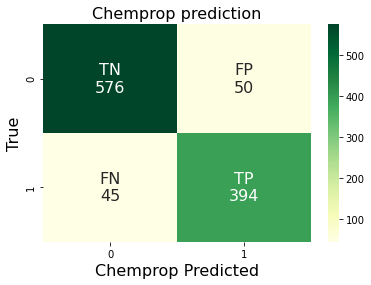

In [111]:
y_true = singleton_testmol['PBT_label']
y_pred = test_final_pred['PBT_bin_pred']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
ax = sns.heatmap(cm, annot=True, fmt='d',cmap='YlGn' , annot_kws={"size": 16},
            cbar_kws={'shrink': 1, 'orientation': 'vertical'})

# Annotate each cell with the respective quadrant label
quadrant_labels = [['TN', 'FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        text = ax.texts[i*2+j]
        text.set_text(f'{quadrant_labels[i][j]}\n{text.get_text()}')

plt.xlabel('Chemprop Predicted', fontsize = 16)
plt.ylabel('True', fontsize = 16)
plt.title('Chemprop prediction', fontsize = 16)

plt.show()


In [112]:
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)  # Sensitivity is the same as recall

# AUC
try:
    auc = roc_auc_score(y_true, y_pred)  # y_pred_prob should be the predicted probabilities
except ValueError:
    auc = None  # Handle cases where AUC can't be computed, e.g., with a single class in y_true

# Specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')

if auc is not None:
    print(f'AUC: {auc:.2f}')
else:
    print('AUC: Not applicable')
print(f'Specificity: {specificity:.2f}')


Accuracy: 0.91
Sensitivity (Recall): 0.90
AUC: 0.91
Specificity: 0.92


## **Conclusions**

The accuracy of the cluster-centroid-based model (0.91) reflects a high overall performance, with only a modest drop compared to random splitting. Despite the increase in structural diversity between the training and test sets, the accuracy remains strong, indicating the model can still correctly classify 91% of compounds. This slight decrease in performance across all metrics is expected, given that the cluster-centroid strategy better mimics real-world conditions, but the fact that the figures remain high (e.g., AUC: 0.91, recall: 0.90) is reassuring. The high recall (0.90) is particularly important in this context, as failing to identify PBT compounds—especially if they are rare—could have serious consequences. In real-world scenarios, false negatives (missed PBTs) are especially problematic, as these compounds can pose significant environmental risks. Even if a model has high accuracy, a low recall would make it inadequate for detecting these critical cases. The strong recall here suggests that the model is highly sensitive to PBTs, minimizing the risk of overlooking harmful compounds. The AUC (0.91) further supports the model's robustness, reflecting its strong ability to distinguish between PBT and non-PBT compounds, even with structurally diverse data. The AUC’s relatively small drop from the random splitting (0.96 to 0.91) confirms the model’s solid discriminative power, which is essential for real-world applications where the diversity of compounds is much greater than in controlled datasets. **Given these findings, we selected the cluster centroids-based model with additional RDKit features as our proposed model for PBT prediction, as it provides the most reliable performance on structurally diverse compounds while maintaining robust predictive capabilities.**